In [107]:
#library(performance)
library(ggplot2)
library(olsrr)
library(eurostat)
options(width=160, repr.plot.width=11, repr.plot.height=7)   

# Cvičení 5: Lineární regrese

**Obsah cvičení:**
- příprava dat
- analýza závislosti regresoru a regresandu
- návrh modelu
- odhad parametrů modelu
- analýza parametrů a reziduí

## Modelování indexu cen nemovitostí

Zabývejme se problematikou modelování kvartálního HPI - House Price Indexu - indexu inflace v cenách nemovitostí. Detaily o indexech jsou na webu Eurostatu zde:
https://ec.europa.eu/eurostat/cache/metadata/en/prc_hpi_inx_esms.htm

**Data:**
- identifikátor: `prc_hpi_q`
- NUTS oblast: Německo (`DE`)
- jednotky: `I10_Q` (kvartální index přepočtený na rok 2015, který má hodnotu 100)
- podmnožina: `purchase == TOTAL`

Data si nejprve stáhneme:

In [39]:
data <- get_eurostat('prc_hpi_q')
head(data)

Reading cache file /tmp/RtmpxkYAH2/eurostat/prc_hpi_q_date_code_FF.rds

Table  prc_hpi_q  read from cache file:  /tmp/RtmpxkYAH2/eurostat/prc_hpi_q_date_code_FF.rds



purchase,unit,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
DW_EXST,I10_Q,AT,2022-07-01,235.42
DW_EXST,I10_Q,BE,2022-07-01,147.18
DW_EXST,I10_Q,BG,2022-07-01,167.01
DW_EXST,I10_Q,CY,2022-07-01,96.62
DW_EXST,I10_Q,CZ,2022-07-01,232.70
DW_EXST,I10_Q,DE,2022-07-01,201.20


Následně vybereme sloupce, které nás budou zajímat.

In [40]:
df <- data[data$geo == "DE",]
df <- df[df$unit == "I10_Q",]
df <- df[df$purchase == 'TOTAL',]
df$geo <- NULL
df$unit <- NULL
df$purchase <- NULL
head(df)
tail(df)

time,values
<date>,<dbl>
2022-07-01,197.9
2022-04-01,198.7
2022-01-01,194.7
2021-10-01,193.9
2021-07-01,188.7
2021-04-01,181.1


time,values
<date>,<dbl>
2006-04-01,99.6
2006-01-01,99.2
2005-10-01,97.8
2005-07-01,100.7
2005-04-01,98.6
2005-01-01,100.4


Sloupec `time` nemá ideální podobu pro regresi. Potřebujeme jej vhodným způsobem transformovat. Jedna z variant je následující:

In [41]:
df$time = seq(2022.5, 2005.0, by=-0.25)

Pohled na data napoví, jaký model bychom mohli uvažovat:

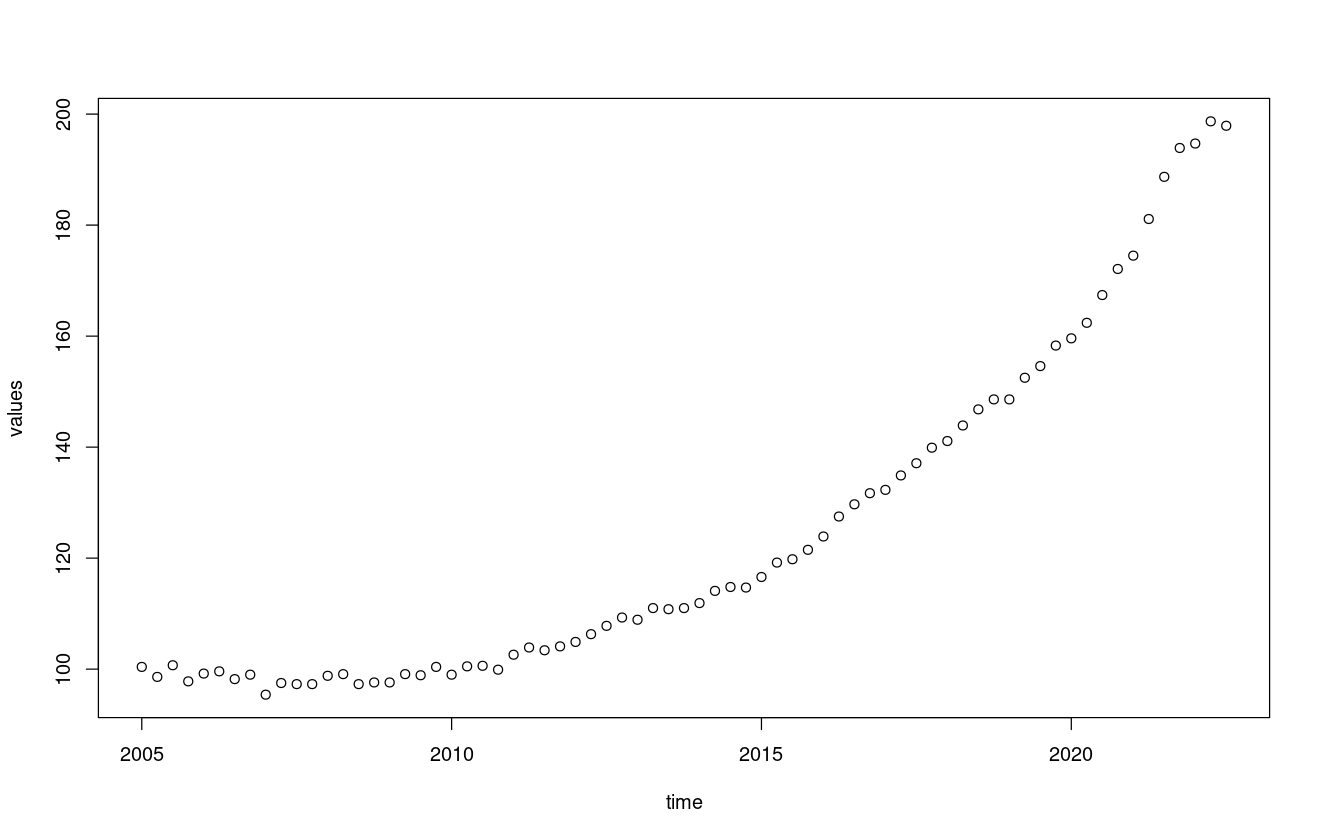

In [42]:
plot(df)

Jeden z prvních kroků může být pokusné vložení regresního polynomu do dat přímo v obrázku. Můžeme zkusit více různých modelů a sledovat, který lépe odpovídá datům.

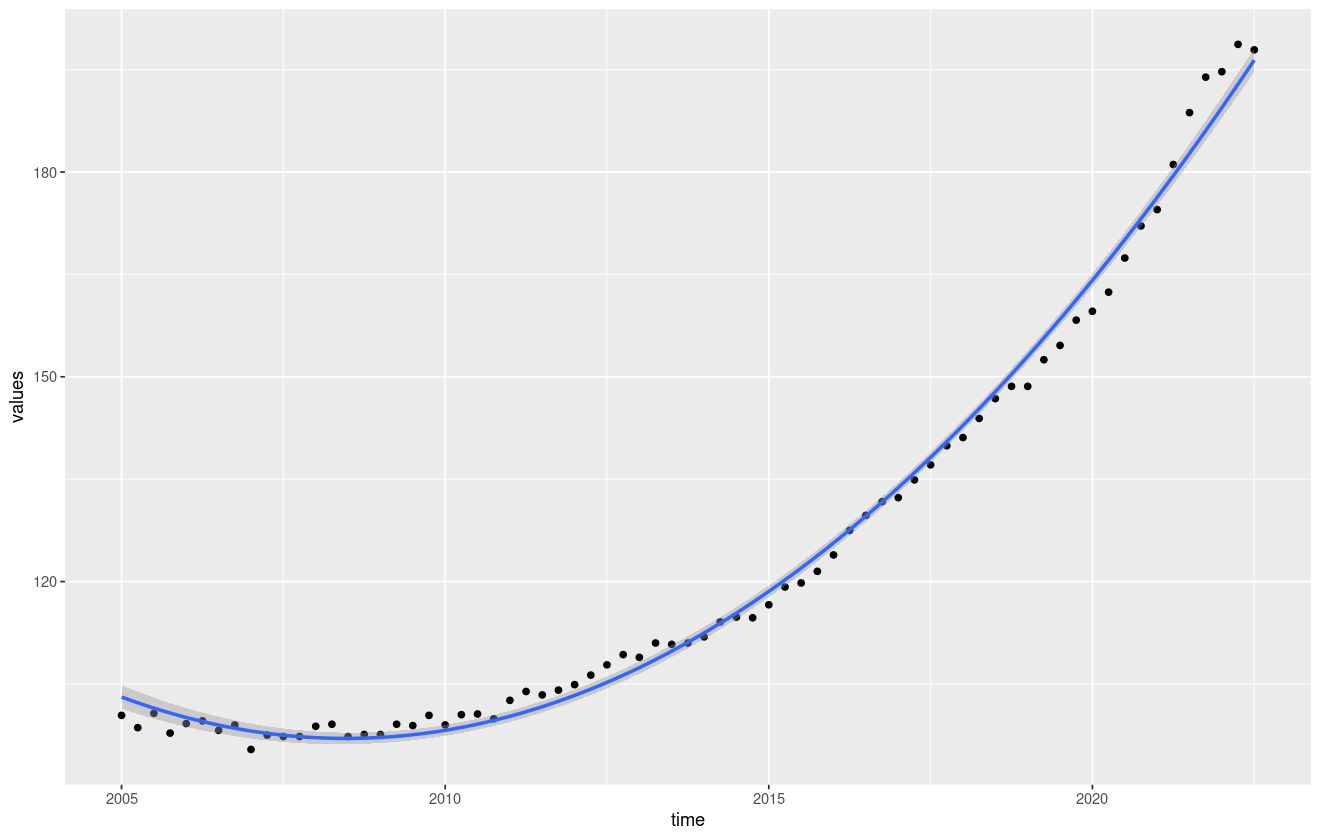

In [43]:
ggplot(df, aes(x=time, y=values)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x+I(x^2))

Máme-li vybraný model, nafitujeme jej. To znamená, odhadneme parametry modelu. Současně si můžeme připravit predikce pro pozdější vykreslení predikčního intervalu:

In [44]:
fit <- lm(values ~ time + I(time^2), data=df)
tmp <- predict(fit, interval="prediction")
df <- cbind(df, tmp)

Warning message in predict.lm(fit, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


Dalším krokem je nutně vyhodnocení modelu. Mimo jiné sledujeme statistickou významnost jednotlivých koeficientů. Není-li koeficient významně odlišný od nuly, můžeme související regresor v modelu vynechat. Dále sledujeme $R^2$ a jeho adjustovanou variantu a $F$-test nezávislosti regresandu na regresorech.

In [45]:
summary(fit)


Call:
lm(formula = values ~ time + I(time^2), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6777 -1.7668 -0.0883  1.6035  7.8515 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.035e+06  5.124e+04   39.72   <2e-16 ***
time        -2.027e+03  5.089e+01  -39.82   <2e-16 ***
I(time^2)    5.045e-01  1.264e-02   39.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.499 on 68 degrees of freedom
Multiple R-squared:  0.9933,	Adjusted R-squared:  0.9931 
F-statistic:  5039 on 2 and 68 DF,  p-value: < 2.2e-16


- `Residuals` - důležité míry polohy reziduí (chyb regrese)
- `Coefficients` - `(Intercept)` je odhad $\hat{\beta}_0$, `wt` je odhad $\hat{\beta}_1$, jednotlivé sloupce mají následující význam: 
    - `Estimate` je hodnota bodového odhadu příslušného koeficientu,
    - `Std. Error` - směrodatná odchylka odhadu
    - `t value` - hodnota testové statistiky
    - `Pr(>|t|)` - p-hodnota testu o nulovosti příslušného koeficientu
- `Residual standard error` - $S_e/(n-k)$ kde $(n-k)$ je počet stupňů volnosti
- `Multiple R-squared` - koeficient determinace $R^2$
- `Adjusted R-squared` - adjustovaný koeficient determinace $R^2$
- `F-statistic` - F-statistika, stupně volnosti a p-hodnota testu, že všechny koeficienty jsou rovny nule.

Jeví-li se model jako vhodný, zajímá nás, jak dobře interpoluje data. Iterpretujte graf!

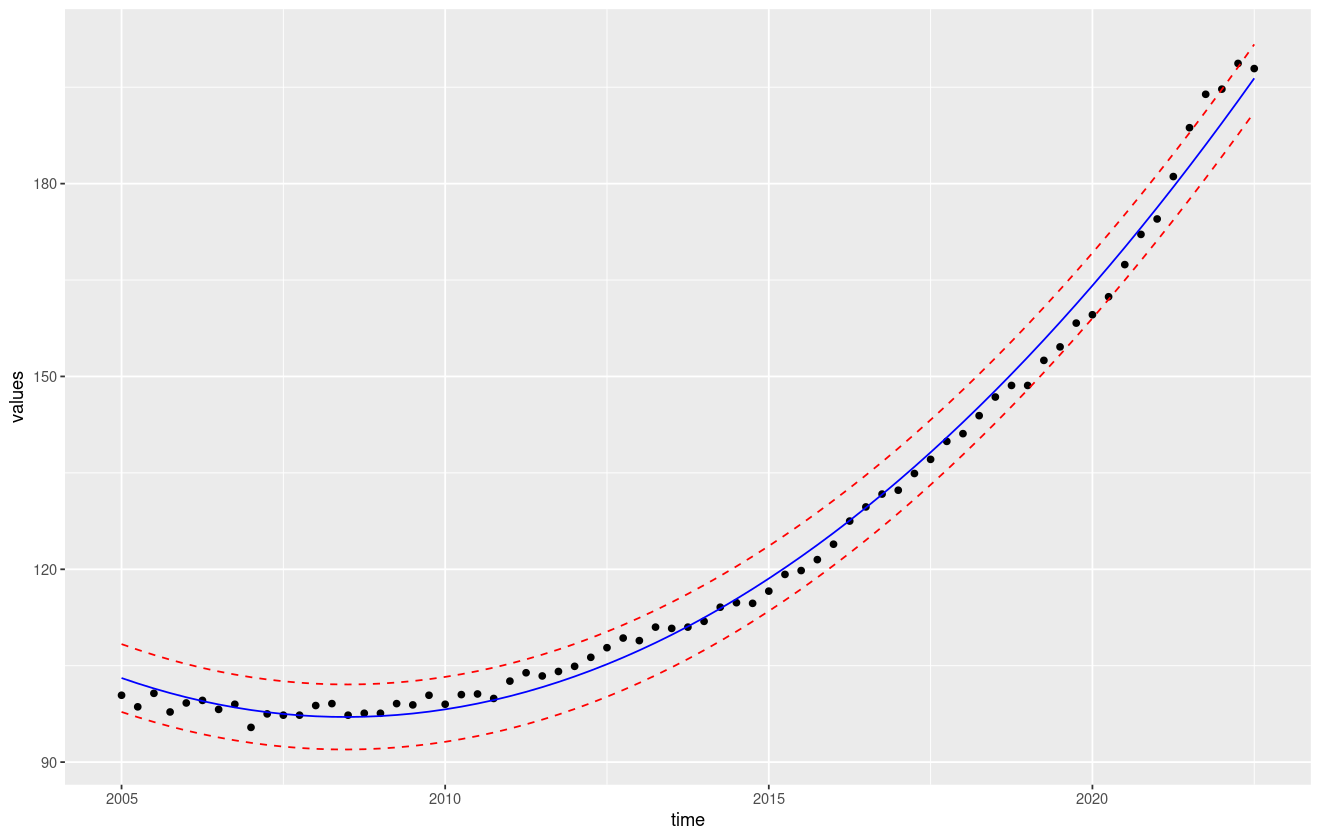

In [108]:
ggplot(df, aes(x=time, y=values)) +
    geom_point() +
    geom_line(aes(y=fit), color="blue") +
    geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
    geom_line(aes(y=upr), color = "red", linetype = "dashed")

Nyní je na řadě analýza reziduí. V grafu reziduí nás zajímá, zda jsou data symetricky rozložena okolo nuly a do jaké míry je přímka, která je vysvětluje, odchylná od vodorovné osy. Analyzujeme, zda rezidua mají nějaký vzor, indikující nedostatečné vysvětlení dat modelem (viz přednáška).

Pokud je nějaký vzor přítomen, často můžeme vysledovat autokorelaci mezi rezidui. To je typické pro časové řady. Použijeme vhodný test.

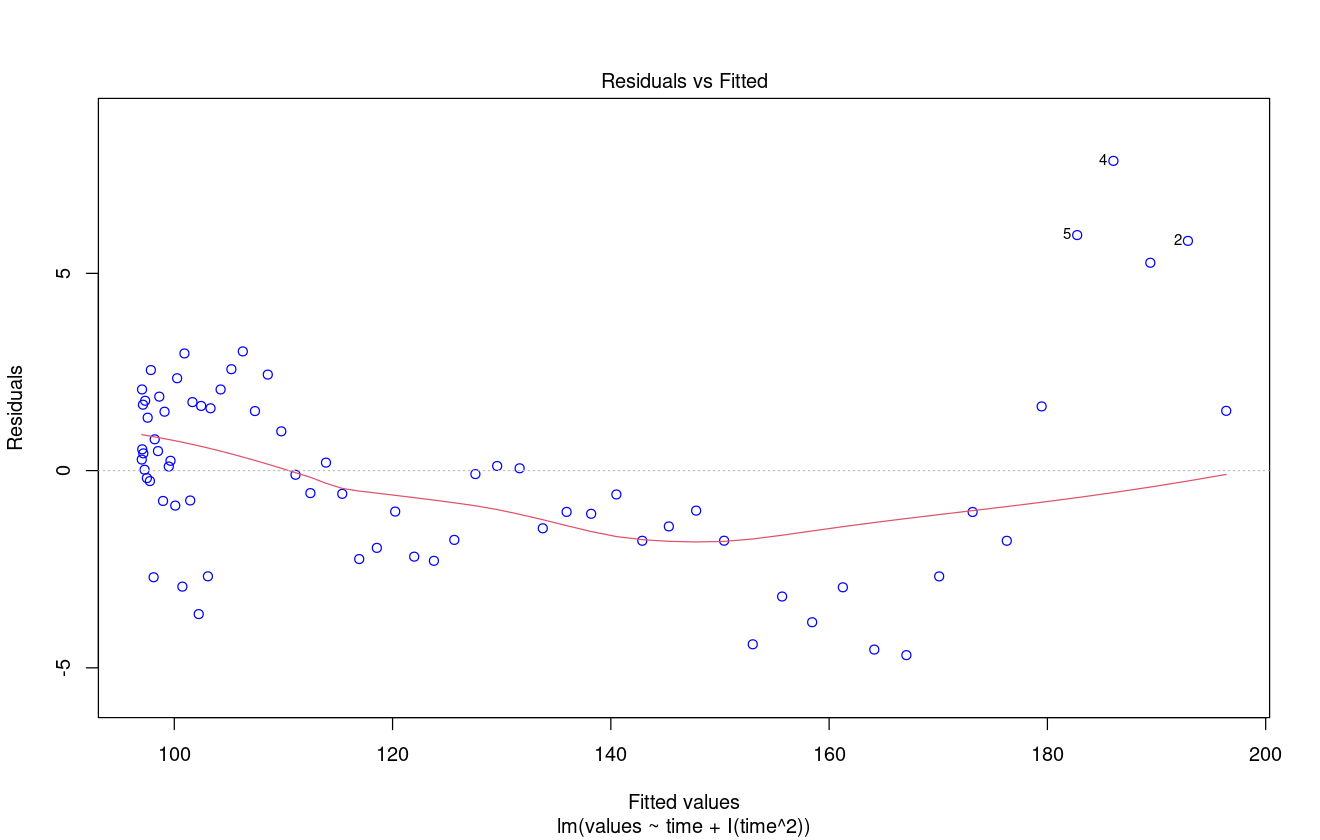

In [47]:
plot(fit, which=1, col=c("blue"))

In [48]:
ols_test_correlation(fit)

[1] 0.9831693

Zajímá nás dále normalita reziduí. Zjišťujeme ji pomocí Q-Q grafu a testujeme vhodným testem (jakým?).

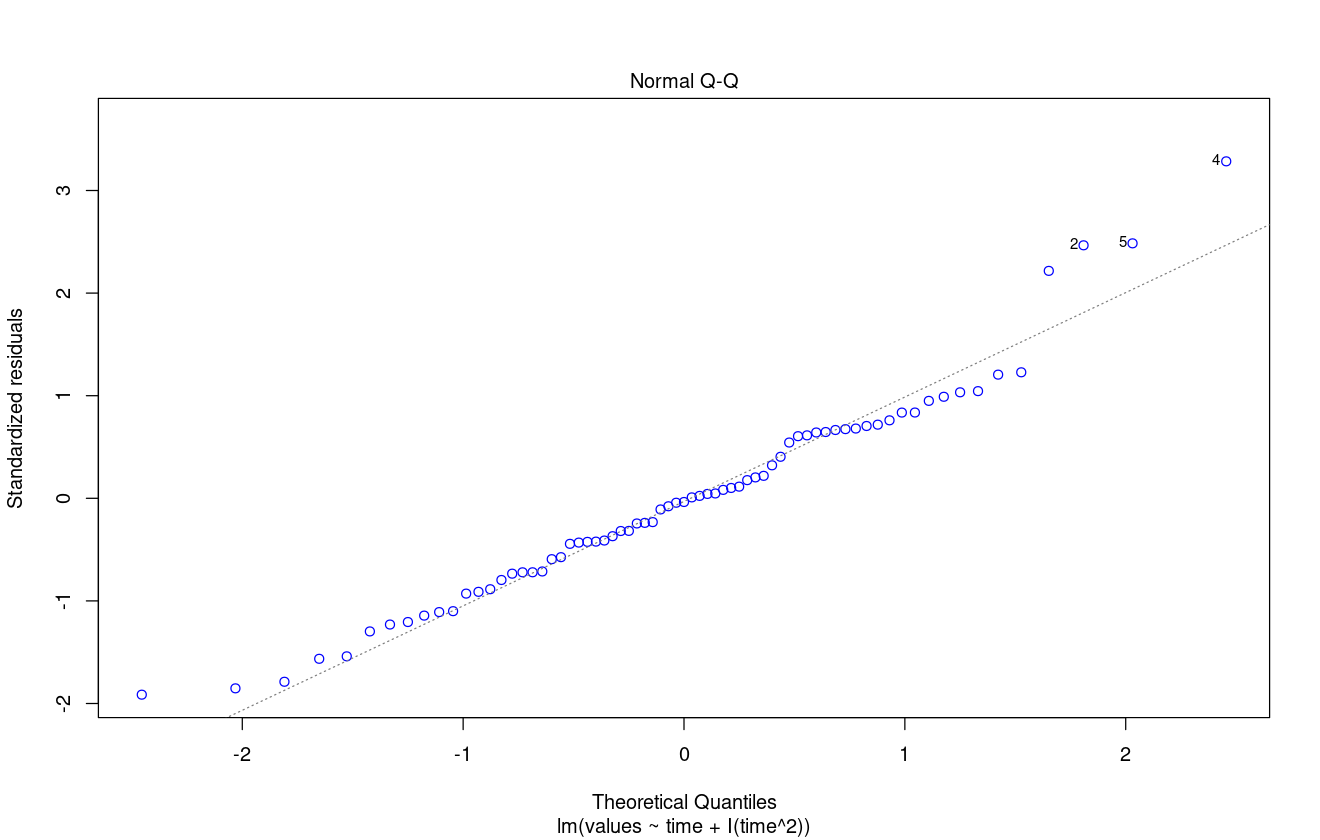

In [49]:
plot(fit, which=2, col=c("blue"))

In [50]:
ols_test_normality(fit)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.9679         0.0660 
Kolmogorov-Smirnov        0.0638         0.9168 
Cramer-von Mises          5.2729         0.0000 
Anderson-Darling          0.472          0.2373 
-----------------------------------------------

Problematickým, leč vcelku běžným jevem je heteroskedasticita šumu, která se projeví i na heteroskedasticitě reziduí. [Heteroskedasticita](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) znamená proměnnost variance (např. v závislosti na čase), opakem je [homoskedasticita](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity). Přítomnost výrazně heteroskedastického šumu typicky vyžaduje vhodnou transformaci dat pro stabilizaci rozptylu.

V grafu níže sledujeme, zda jsou body rozloženy symetricky okolo červené křivky. K dispozici je i statistický test.

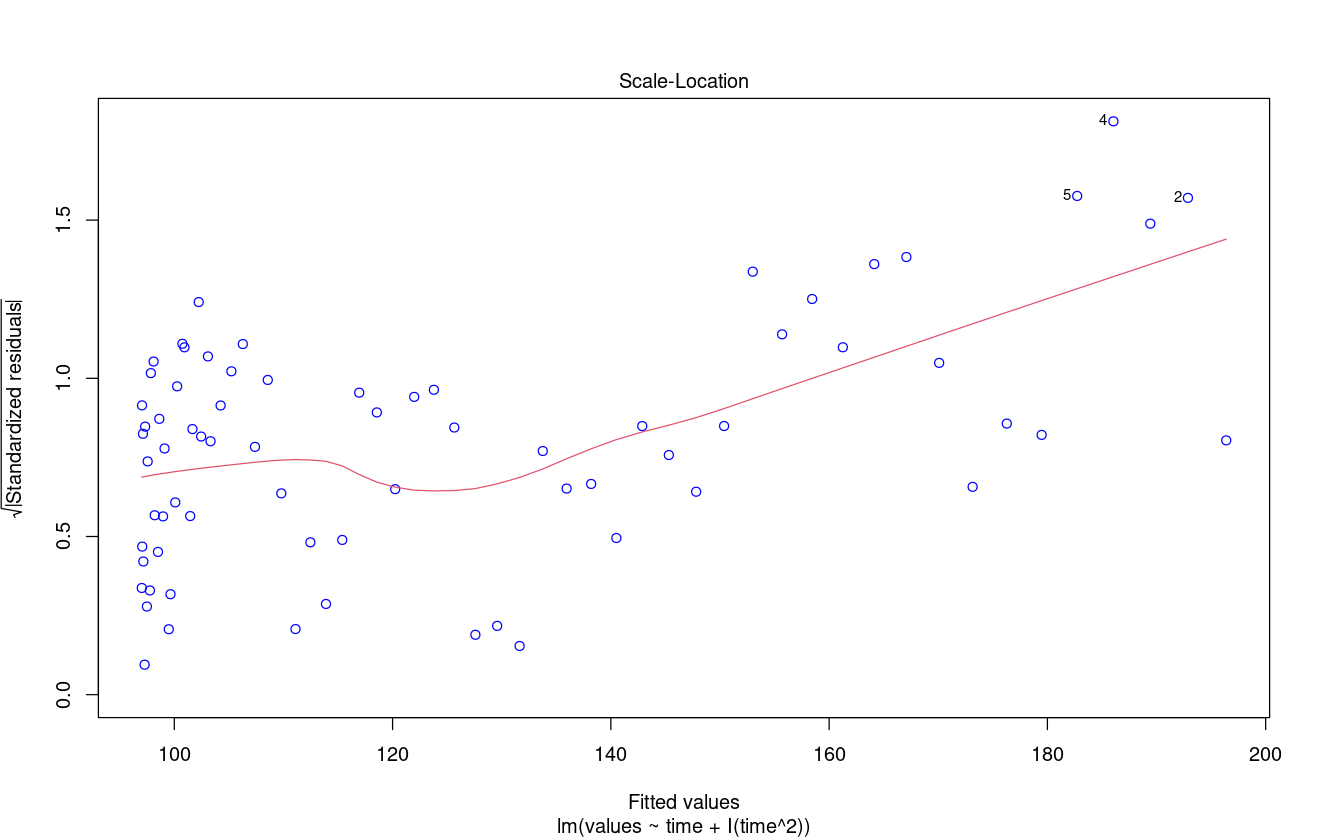

In [51]:
plot(fit, which=3, col=c("blue"))

In [52]:
ols_test_breusch_pagan(fit)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

               Data                
 ----------------------------------
 Response : values 
 Variables: fitted values of values 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    31.41769 
 Prob > Chi2   =    2.080763e-08 

Dalším krokem může být vyšetření [Cookovy vzdálenosti](https://en.wikipedia.org/wiki/Cook%27s_distance). Ta indikuje míru vlivu jednotlivých pozorování na hodnoty odhadů parametrů modelu. Dokážeme tak detekovat odlehlá pozorování (outliery), která mají zásadní vliv a jejichž vyfiltrování by mohlo zlepšit vlastnosti modelu.

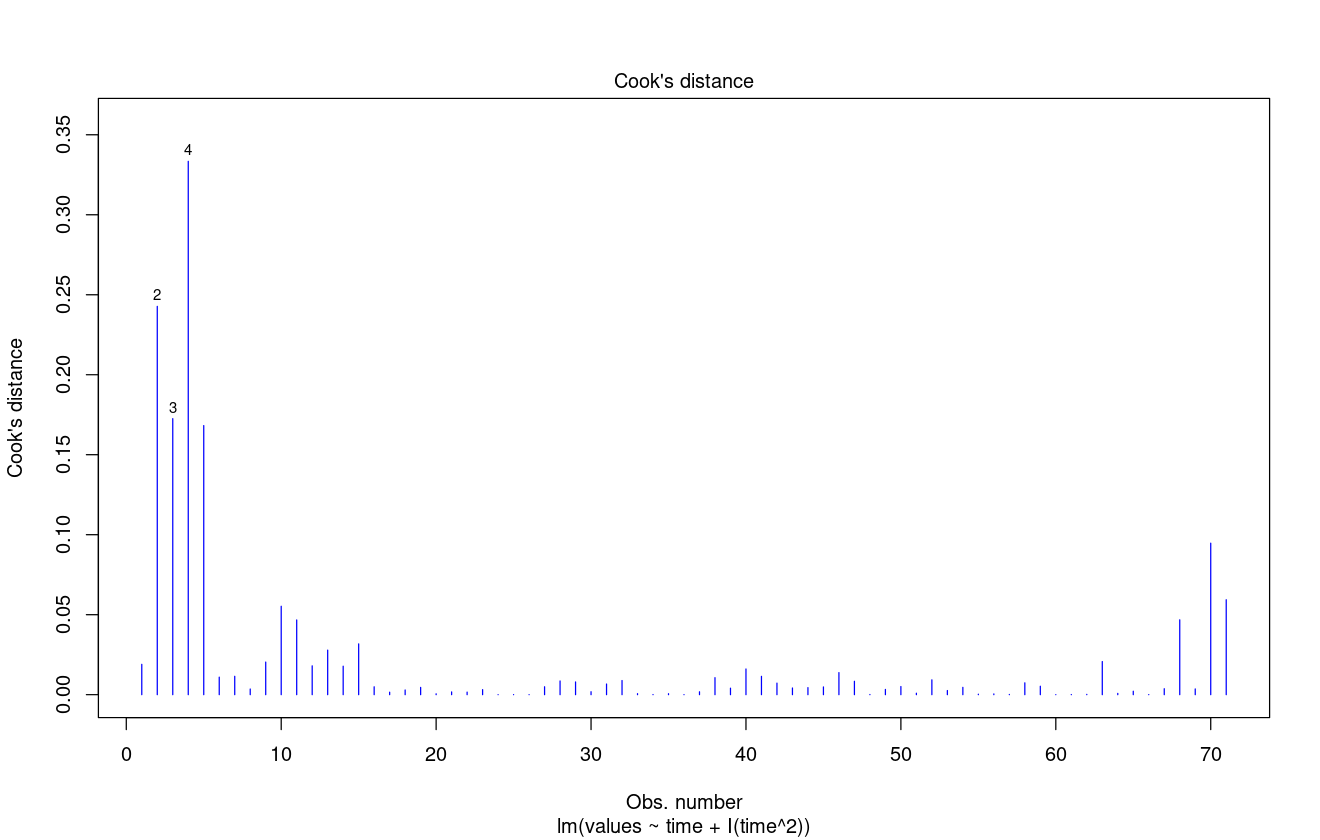

In [53]:
plot(fit, which=4, col=c("blue"))

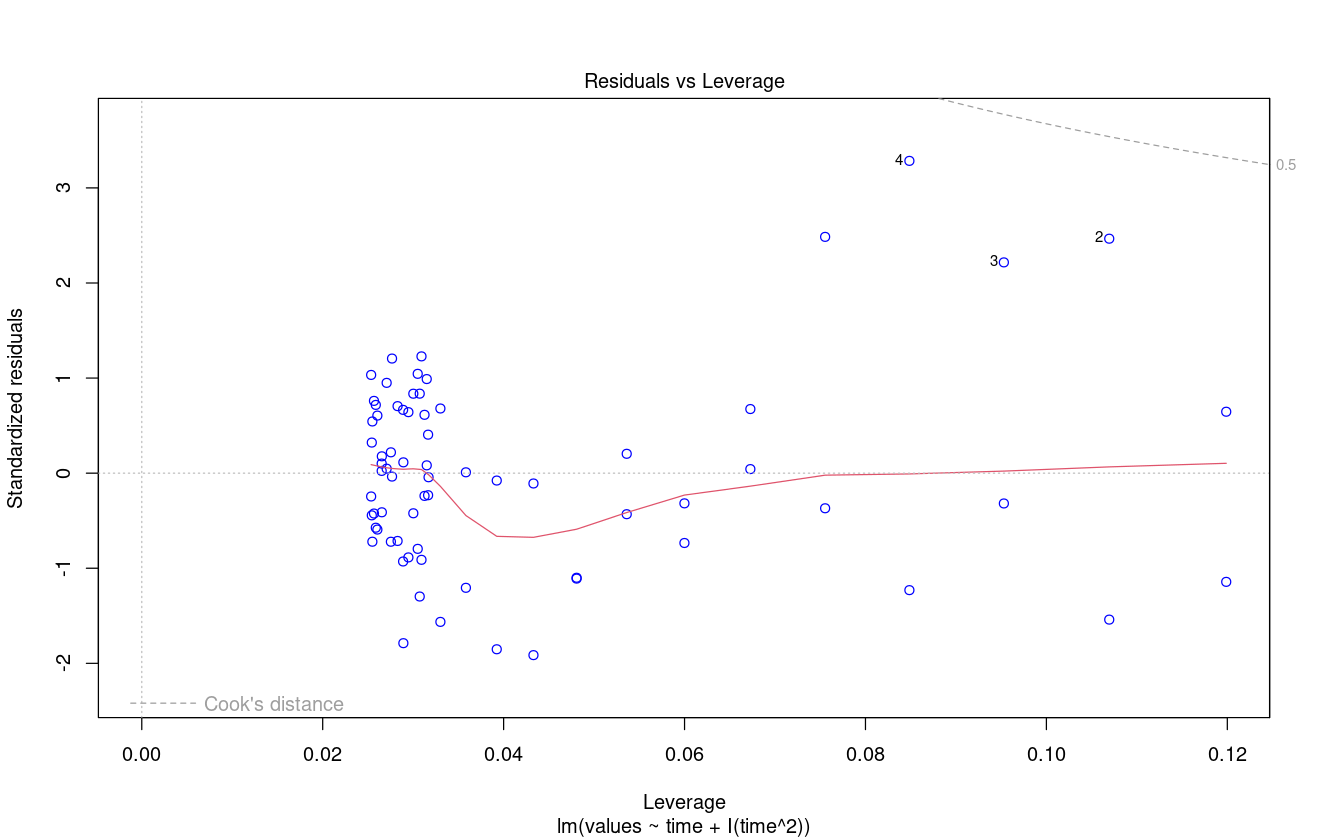

In [54]:
plot(fit, which=5, col=c("blue"))

## Predikce budoucích hodnot

Nyní zkusíme predikovat budoucí hodnoty. Nejprve si ověříme, kde končí stávající datová sada.

In [86]:
head(df)

,time,values,fit,lwr,upr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022.50,197.9,196.3852,191.1081,201.6623
2,2022.25,198.7,192.8766,187.6300,198.1231
3,2022.00,194.7,189.4310,184.2121,194.6499
4,2021.75,193.9,186.0485,180.8546,191.2424
5,2021.50,188.7,182.7290,177.5574,187.9006
6,2021.25,181.1,179.4726,174.3210,184.6243


Potřebujeme vytvořit nový data.frame, který bude obsahovat budoucí časové okamžiky. Není od věci zachovat systém v pořadí. Dosud byly nejnovější data nahoře, proto je rozumné mít podobně seřazené i budoucí predikce.

In [99]:
future <- data.frame(time=seq(2025, 2022.75, by=-.25))

Funkci `predict()` již známe. Předáme jí tedy data. Jelikož budeme později vykreslovat data stávající i budoucí predikovaná a budeme spojovat příslušné data.framy, připravíme si predikce tak, aby byly kompatibilní se stávajícími daty.

In [106]:
fcast <- predict(fit, future, interval='prediction')
future <- cbind(future, fcast)
future$values <- future$fit
head(future)

,time,fit,lwr,upr,values,fit,lwr,upr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2025.00,234.9402,229.1694,240.7111,234.9402,234.9402,229.1694,240.7111
2,2024.75,230.8009,225.0967,236.5052,230.8009,230.8009,225.0967,236.5052
3,2024.50,226.7247,221.0829,232.3665,226.7247,226.7247,221.0829,232.3665
4,2024.25,222.7116,217.1282,228.2949,222.7116,222.7116,217.1282,228.2949
5,2024.00,218.7615,213.2327,224.2903,218.7615,218.7615,213.2327,224.2903
6,2023.75,214.8744,209.3964,220.3525,214.8744,214.8744,209.3964,220.3525


Data můžeme nyní spojit:

In [101]:
df.fcast <- rbind(future, df)
head(df.fcast)

,time,fit,lwr,upr,values
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2025.00,234.9402,229.1694,240.7111,234.9402
2,2024.75,230.8009,225.0967,236.5052,230.8009
3,2024.50,226.7247,221.0829,232.3665,226.7247
4,2024.25,222.7116,217.1282,228.2949,222.7116
5,2024.00,218.7615,213.2327,224.2903,218.7615
6,2023.75,214.8744,209.3964,220.3525,214.8744


Jak vypadají data, predikční intervaly a budoucí predikované hodnoty ukazuje následující obrázek. Jak by se vyvíjely predikční intervaly do delší budoucnosti? (ověřte!)

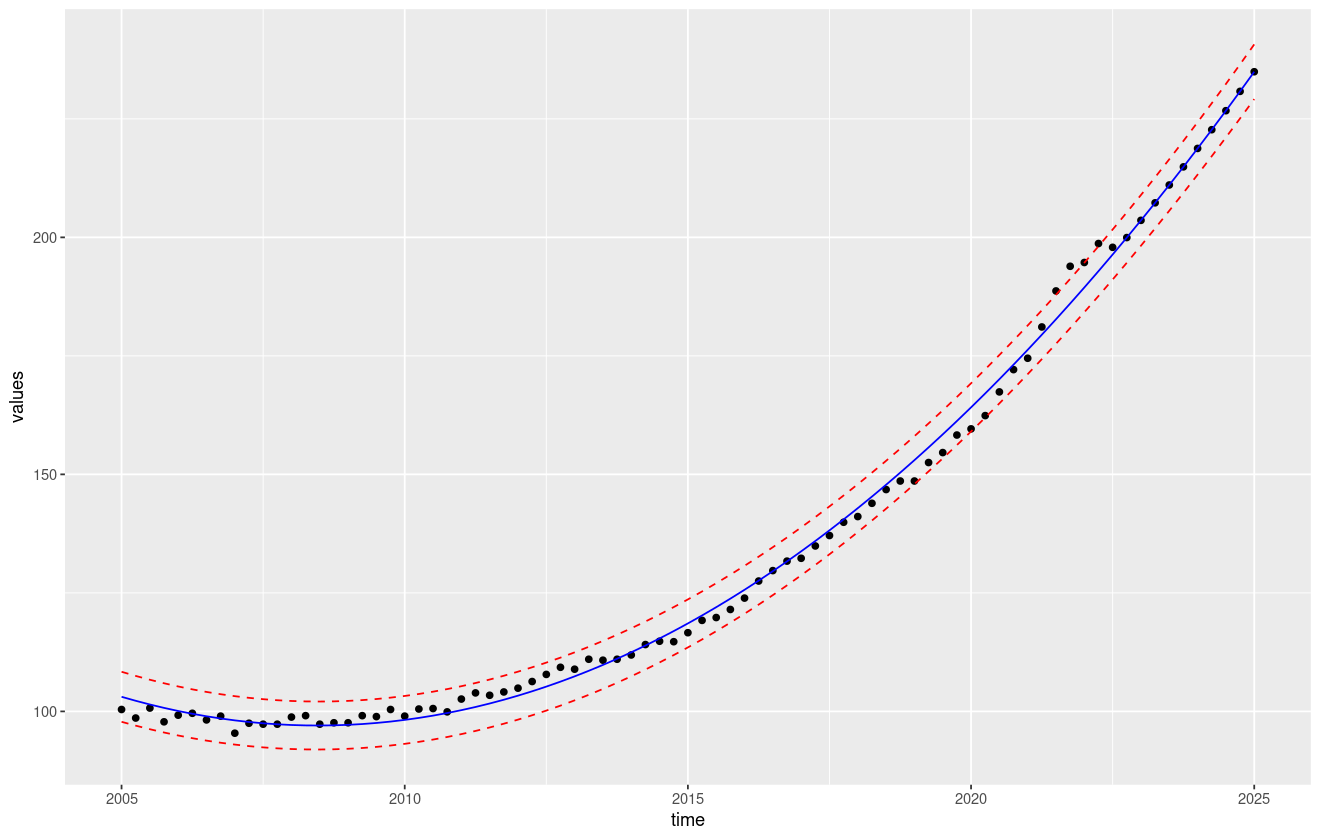

In [105]:
ggplot(df.fcast, aes(x=time, y=values)) +
    geom_point() +
    geom_line(aes(y=fit), color = "blue") +
    geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
    geom_line(aes(y=upr), color = "red", linetype = "dashed")

---
---